# FilmFusion Content-Based Models

This notebook implements content-based recommendation models using:

1. **TF-IDF Content Model**: Using movie plot summaries
2. **Metadata-Based Model**: Using genres, cast, and other features
3. **Hybrid Content Model**: Combining multiple content features
4. **Performance Evaluation**: Comparison with collaborative filtering

## Prerequisites
- Completed feature engineering notebook
- TF-IDF features and embeddings available
- Enriched movie metadata


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import logging
import json
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import sparse

In [3]:
sys.path.append('../')
# Import FilmFusion components
from src.models.content_based.tfidf_recommender import TFIDFRecommender
from src.evaluation.metrics import RecommendationMetrics
from config.logging_config import setup_logging
from src.models.content_based.Metadata_based_content_recommender import MetadataContentRecommender

🏷️ BUILDING METADATA-BASED CONTENT MODEL


In [4]:
# Setup
logger = setup_logging()
plt.style.use('seaborn-v0_8')
np.random.seed(42)

In [5]:
# Load all required data for content-based models
processed_dir = Path('../data/processed')
features_dir = Path('../data/features')
enriched_dir = Path('../data/enriched')
models_dir = Path('../models')

In [6]:
# Load ratings data
ratings_df = pd.read_csv(processed_dir / 'ratings_cleaned.csv')
print(f" Ratings: {len(ratings_df):,} records")

# Load enriched movies data
enriched_movies = pd.read_csv(enriched_dir / 'movies_enriched.csv')
print(f" Enriched movies: {len(enriched_movies):,} records")


 Ratings: 100,836 records
 Enriched movies: 5,922 records


In [7]:
# Load TF-IDF features
try:
    tfidf_matrix = sparse.load_npz(features_dir / 'tfidf_matrix.npz')
    print(f" TF-IDF matrix: {tfidf_matrix.shape}")
    
    with open(features_dir / 'tfidf_feature_names.json', 'r') as f:
        tfidf_feature_names = json.load(f)
    print(f" TF-IDF features: {len(tfidf_feature_names)} features")
    
    tfidf_movie_mapping = pd.read_csv(features_dir / 'tfidf_movie_mapping.csv')
    print(f" TF-IDF movie mapping: {len(tfidf_movie_mapping)} movies")
    
except FileNotFoundError as e:
    print(f" TF-IDF features not found: {e}")
    tfidf_matrix = None


 TF-IDF matrix: (5918, 5000)
 TF-IDF features: 5000 features
 TF-IDF movie mapping: 5918 movies


In [8]:
# Load embeddings
try:
    movie_embeddings = np.load(features_dir / 'movie_embeddings.npy')
    print(f" Movie embeddings: {movie_embeddings.shape}")
except FileNotFoundError:
    print(" Movie embeddings not found")
    movie_embeddings = None


 Movie embeddings: (5922, 200)


In [9]:
# Load numerical features
try:
    numerical_features = np.load(features_dir / 'numerical_features.npy')
    with open(features_dir / 'numerical_feature_names.json', 'r') as f:
        numerical_feature_names = json.load(f)
    print(f" Numerical features: {numerical_features.shape}")
except FileNotFoundError:
    print(" Numerical features not found")
    numerical_features = None

 Numerical features: (5922, 7)


In [10]:
# Create train/test split (same as collaborative filtering)
train_df = ratings_df.sample(frac=0.8, random_state=42)
test_df = ratings_df.drop(train_df.index)
print(f"\n Train/Test Split:")
print(f"Training: {len(train_df):,} ratings")
print(f"Testing: {len(test_df):,} ratings")


 Train/Test Split:
Training: 80,669 ratings
Testing: 20,167 ratings


 TRAINING TF-IDF CONTENT-BASED MODEL
Training TF-IDF recommender...
2025-07-30 12:21:19,016 - src.models.base_recommender - INFO - Training TF-IDF Content-Based Recommender...
2025-07-30 12:21:19,023 - src.models.base_recommender - INFO - Computing cosine similarity matrix...
2025-07-30 12:21:19,380 - src.models.base_recommender - INFO - ✅ TF-IDF Content-Based Recommender training completed
2025-07-30 12:21:19,382 - src.models.base_recommender - INFO - Similarity matrix shape: (5918, 5918)
 TF-IDF model training completed in 0.4 seconds

 MOVIE SIMILARITY EXAMPLES:
Movies similar to 'The Angry Red Planet':
  - Robinson Crusoe on Mars (similarity: 0.287)
  - Aelita: Queen of Mars (similarity: 0.261)
  - Doctor Who: The Waters of Mars (similarity: 0.217)
  - The Martian (similarity: 0.200)
  - Veronica Mars (similarity: 0.186)

 SAMPLE TF-IDF RECOMMENDATIONS:

User 432:
  1. Suspect Zero (score: 0.708)
  2. Factory Girl (score: 0.566)
  3. Shrek the Third (score: 0.550)
  4. Just My Luck

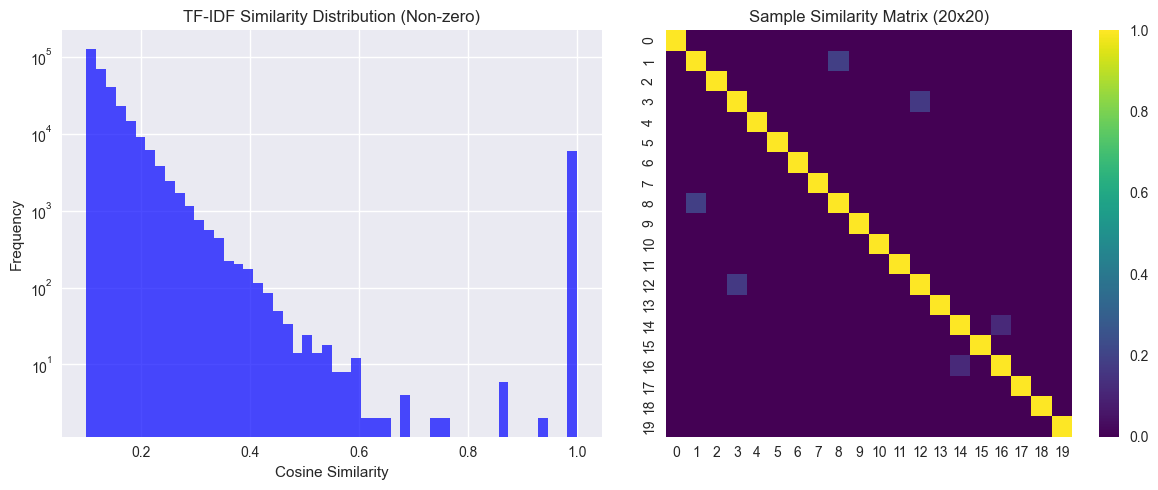

In [17]:
# Train TF-IDF content-based recommender
print(" TRAINING TF-IDF CONTENT-BASED MODEL")
print("=" * 40)

if tfidf_matrix is not None:
    # Initialize TF-IDF recommender
    tfidf_recommender = TFIDFRecommender(similarity_threshold=0.1)
    
    # Prepare movies data for TF-IDF model
    tfidf_movies_df = tfidf_movie_mapping.merge(
        enriched_movies[['movieId', 'tmdb_title', 'year', 'genres_tmdb']], 
        on='movieId', 
        how='left'
    )
    
    # Train the model
    print("Training TF-IDF recommender...")
    start_time = datetime.now()
    
    tfidf_recommender.fit(
        ratings_df=train_df,
        tfidf_matrix=tfidf_matrix,
        movies_df=tfidf_movies_df
    )
    
    training_time = (datetime.now() - start_time).total_seconds()
    print(f" TF-IDF model training completed in {training_time:.1f} seconds")
    
    # Test similar movie functionality
    print(f"\n MOVIE SIMILARITY EXAMPLES:")
    
    # Get a sample movie and find similar ones
    sample_movie_id = tfidf_movies_df.iloc[0]['movieId']
    sample_movie_title = tfidf_movies_df.iloc[0]['tmdb_title_x']
    
    similar_movies = tfidf_recommender.get_similar_movies(sample_movie_id, n_similar=5)
    
    print(f"Movies similar to '{sample_movie_title}':")
    for movie_id, similarity_score in similar_movies:
        similar_movie = tfidf_movies_df[tfidf_movies_df['movieId'] == movie_id]
        if len(similar_movie) > 0:
            title = similar_movie.iloc[0]['tmdb_title_x']
            print(f"  - {title} (similarity: {similarity_score:.3f})")
    
    # Generate sample recommendations
    print(f"\n SAMPLE TF-IDF RECOMMENDATIONS:")
    sample_users = train_df['userId'].unique()[:5]
    
    for user_id in sample_users:
        try:
            recommendations = tfidf_recommender.recommend(user_id, n_recommendations=5)
            print(f"\nUser {user_id}:")
            for i, (movie_id, score) in enumerate(recommendations, 1):
                movie_info = tfidf_movies_df[tfidf_movies_df['movieId'] == movie_id]
                if len(movie_info) > 0:
                    title = movie_info.iloc[0]['tmdb_title_x']
                    print(f"  {i}. {title} (score: {score:.3f})")
                else:
                    print(f"  {i}. Movie {movie_id} (score: {score:.3f})")
        except Exception as e:
            print(f"User {user_id}: Error - {e}")
    
    # Analyze similarity matrix properties
    print(f"\n TF-IDF SIMILARITY ANALYSIS:")
    similarity_matrix = tfidf_recommender.similarity_matrix
    
    # Calculate similarity statistics
    non_zero_similarities = similarity_matrix[similarity_matrix > 0]
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    print(f"Non-zero similarities: {len(non_zero_similarities):,} ({len(non_zero_similarities)/(similarity_matrix.size)*100:.2f}%)")
    print(f"Mean similarity: {non_zero_similarities.mean():.3f}")
    print(f"Max similarity: {non_zero_similarities.max():.3f}")
    print(f"Min similarity (>0): {non_zero_similarities.min():.3f}")
    
    # Visualize similarity distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(non_zero_similarities, bins=50, alpha=0.7, color='blue')
    plt.title('TF-IDF Similarity Distribution (Non-zero)')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    # Sample similarity heatmap (first 20x20)
    sample_sim = similarity_matrix[:20, :20]
    sns.heatmap(sample_sim, cmap='viridis', square=True)
    plt.title('Sample Similarity Matrix (20x20)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot train TF-IDF model - features not available")
    tfidf_recommender = None


In [19]:
# Train metadata model
metadata_recommender = MetadataContentRecommender()

print("Training metadata-based recommender...")
start_time = datetime.now()

metadata_recommender.fit(enriched_movies, train_df)

training_time = (datetime.now() - start_time).total_seconds()
print(f"Metadata model training completed in {training_time:.1f} seconds")

# Test metadata recommendations
print(f"\nSAMPLE METADATA RECOMMENDATIONS:")
for user_id in sample_users:
    try:
        recommendations = metadata_recommender.recommend(user_id, train_df, n_recommendations=5)
        print(f"\nUser {user_id}:")
        for i, (movie_id, score) in enumerate(recommendations, 1):
            movie_info = enriched_movies[enriched_movies['movieId'] == movie_id]
            if len(movie_info) > 0:
                title = movie_info.iloc[0]['tmdb_title']
                year = movie_info.iloc[0]['year']
                print(f"  {i}. {title} ({year}) - Score: {score:.3f}")
            else:
                print(f"  {i}. Movie {movie_id} - Score: {score:.3f}")
    except Exception as e:
        print(f"User {user_id}: Error - {e}")

Training metadata-based recommender...
Found 19 unique genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History']...
Created metadata feature matrix: (5922, 22)
Features: 22 total
Computing metadata similarity matrix...
Metadata model trained successfully
Metadata model training completed in 1.2 seconds

SAMPLE METADATA RECOMMENDATIONS:

User 432:
  1. Atonement (2007.0) - Score: 4.299
  2. The Reader (2008.0) - Score: 4.299
  3. Becoming Jane (2007.0) - Score: 4.298
  4. The Painted Veil (2006.0) - Score: 4.298
  5. Fireproof (2008.0) - Score: 3.499

User 288:
  1. EuroTrip (2004.0) - Score: 3.200
  2. Old School (2003.0) - Score: 3.200
  3. Bring It On: All or Nothing (2006.0) - Score: 3.200
  4. Son of Rambow (2007.0) - Score: 3.200
  5. The Boss of It All (2006.0) - Score: 3.200

User 599:
  1. Dragon Ball Z: Bojack Unbound (1993.0) - Score: 5.306
  2. Redline (2009.0) - Score: 4.650
  3. Appleseed (2004.0) - Score: 4.650

In [20]:
# Evaluate content-based models
# Initialize metrics calculator
metrics_calculator = RecommendationMetrics()

In [21]:
def evaluate_content_model(model, model_name, test_df, train_df, n_recommendations=10):
    """Evaluate a content-based model"""
    print(f"\nEvaluating {model_name}...")
    
    # Generate recommendations for test users
    test_users = test_df['userId'].unique()[:100]  # Sample for faster evaluation
    
    recommendations = {}
    successful_recs = 0
    
    for user_id in test_users:
        try:
            if hasattr(model, 'recommend'):
                if model_name == "Metadata":
                    recs = model.recommend(user_id, train_df, n_recommendations)
                else:
                    recs = model.recommend(user_id, n_recommendations)
                
                if recs:
                    recommendations[user_id] = recs
                    successful_recs += 1
        except Exception as e:
            continue
    
    print(f"Generated recommendations for {successful_recs}/{len(test_users)} users")
    
    if not recommendations:
        print(f"No recommendations generated for {model_name}")
        return None
    
    # Calculate precision@k and recall@k
    precision_scores = []
    recall_scores = []
    
    for user_id, user_recs in recommendations.items():
        # Get user's test items (relevant items)
        user_test_ratings = test_df[test_df['userId'] == user_id]
        relevant_items = set(user_test_ratings[user_test_ratings['rating'] >= 4.0]['movieId'])
        
        if len(relevant_items) == 0:
            continue
        
        # Extract recommended item IDs
        recommended_items = [item_id for item_id, _ in user_recs]
        
        # Calculate metrics
        precision = metrics_calculator.precision_at_k(recommended_items, relevant_items, n_recommendations)
        recall = metrics_calculator.recall_at_k(recommended_items, relevant_items, n_recommendations)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    # Calculate averages
    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0
    avg_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    # Calculate coverage
    all_recommended_items = set()
    for user_recs in recommendations.values():
        all_recommended_items.update([item_id for item_id, _ in user_recs])
    
    total_items = len(enriched_movies)
    coverage = len(all_recommended_items) / total_items
    
    results = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
        'coverage': coverage,
        'users_with_recs': successful_recs,
        'total_users': len(test_users)
    }
    
    print(f"Results for {model_name}:")
    print(f"  Precision@{n_recommendations}: {avg_precision:.4f}")
    print(f"  Recall@{n_recommendations}: {avg_recall:.4f}")
    print(f"  F1@{n_recommendations}: {avg_f1:.4f}")
    print(f"  Coverage: {coverage:.4f}")
    
    return results


Evaluating TF-IDF...
Generated recommendations for 100/100 users
Results for TF-IDF:
  Precision@10: 0.0495
  Recall@10: 0.0592
  F1@10: 0.0539
  Coverage: 0.0708

Evaluating Metadata...
Generated recommendations for 61/100 users
Results for Metadata:
  Precision@10: 0.0333
  Recall@10: 0.0166
  F1@10: 0.0222
  Coverage: 0.0579

 CONTENT-BASED MODEL COMPARISON:


,precision,recall,f1,coverage,users_with_recs,total_users
TF-IDF,0.0495,0.0592,0.0539,0.0708,100.0,100.0
Metadata,0.0333,0.0166,0.0222,0.0579,61.0,100.0


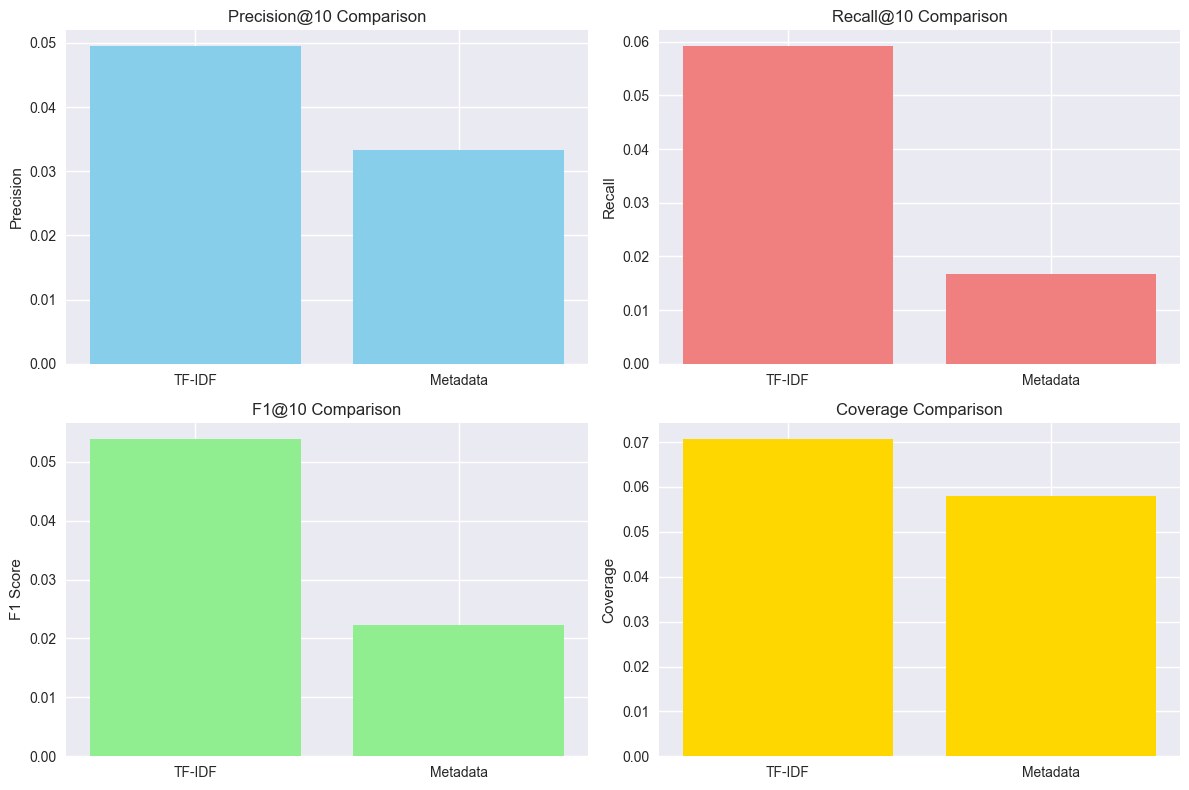

In [22]:
# Evaluate models
evaluation_results = {}

# Evaluate TF-IDF model
if tfidf_recommender is not None:
    tfidf_results = evaluate_content_model(tfidf_recommender, "TF-IDF", test_df, train_df)
    if tfidf_results:
        evaluation_results['TF-IDF'] = tfidf_results

# Evaluate Metadata model
metadata_results = evaluate_content_model(metadata_recommender, "Metadata", test_df, train_df)
if metadata_results:
    evaluation_results['Metadata'] = metadata_results

# Create comparison visualization
if evaluation_results:
    results_df = pd.DataFrame(evaluation_results).T
    
    print(f"\n CONTENT-BASED MODEL COMPARISON:")
    display(results_df.round(4))
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    models = list(evaluation_results.keys())
    
    # Precision comparison
    precision_values = [evaluation_results[model]['precision'] for model in models]
    axes[0, 0].bar(models, precision_values, color='skyblue')
    axes[0, 0].set_title('Precision@10 Comparison')
    axes[0, 0].set_ylabel('Precision')
    
    # Recall comparison
    recall_values = [evaluation_results[model]['recall'] for model in models]
    axes[0, 1].bar(models, recall_values, color='lightcoral')
    axes[0, 1].set_title('Recall@10 Comparison')
    axes[0, 1].set_ylabel('Recall')
    
    # F1 comparison
    f1_values = [evaluation_results[model]['f1'] for model in models]
    axes[1, 0].bar(models, f1_values, color='lightgreen')
    axes[1, 0].set_title('F1@10 Comparison')
    axes[1, 0].set_ylabel('F1 Score')
    
    # Coverage comparison
    coverage_values = [evaluation_results[model]['coverage'] for model in models]
    axes[1, 1].bar(models, coverage_values, color='gold')
    axes[1, 1].set_title('Coverage Comparison')
    axes[1, 1].set_ylabel('Coverage')
    
    plt.tight_layout()
    plt.show()

In [23]:
# Save model results
content_model_results = {
    'evaluation_timestamp': datetime.now().isoformat(),
    'models_evaluated': list(evaluation_results.keys()),
    'evaluation_results': evaluation_results,
    'test_users_sample_size': 100,
    'recommendations_per_user': 10
}

with open(models_dir / 'content_model_results.json', 'w') as f:
    json.dump(content_model_results, f, indent=2, default=str)

print(f"\n Content model results saved to {models_dir / 'content_model_results.json'}")
print(f" Content-based model training and evaluation completed!")


 Content model results saved to ..\models\content_model_results.json
 Content-based model training and evaluation completed!
